# Amazon Fine Food Reviews

https://www.kaggle.com/snap/amazon-fine-food-reviews

## Hyperparameters

In [1]:
hyperparameters = {
    'limit': 10000,
    'min_words': 2,
    'max_words': 200,
    'num_features': 20000,
    'downsample_ratio': 0.2,
    'rf_num_trees': 10,
    'rf_max_categories': 5,
    'nb_smoothing': 0.1,
    'lr_iterations': 10, 
    'lr_regparam': 0.3,
    'lr_elastic': 0.8
}

## Load Dataset

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

from wordcloud import WordCloud, STOPWORDS
from pyspark.sql.functions import *
from pyspark.sql.types import StructType, StructField, IntegerType, StringType
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, HashingTF, IDF
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import ClusteringEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.mllib.util import MLUtils
from pyspark.mllib.evaluation import MulticlassMetrics

df = spark.read.csv('Reviews.csv',header=False, schema=StructType([
    StructField('Id', IntegerType(), True),
    StructField('ProductId', StringType(), True),
    StructField('UserId', StringType(), True),
    StructField('ProfileName', StringType(), True),
    StructField('HelpfulnessNumerator', IntegerType(), True),
    StructField('HelpfulnessDenominator', IntegerType(), True),
    StructField('Score', IntegerType(), True),
    StructField('Time', IntegerType(), True),
    StructField('Summary', StringType(), True),
    StructField('Text', StringType(), True)]))
df = df.select('Id', 'Text', 'Summary', 'Score').withColumnRenamed('Score', 'label')
if hyperparameters['limit'] > 0:
    df = df.limit(hyperparameters['limit'])
df = df.filter('Id' > 0 and length('Text') > 0).filter(col('label') > 0)

df.show()

+---+--------------------+--------------------+-----+
| Id|                Text|             Summary|label|
+---+--------------------+--------------------+-----+
|  1|I have bought sev...|Good Quality Dog ...|    5|
|  2|"Product arrived ...|   Not as Advertised|    1|
|  3|"This is a confec...|"""Delight"" says...|    4|
|  4|If you are lookin...|      Cough Medicine|    2|
|  5|Great taffy at a ...|         Great taffy|    5|
|  6|I got a wild hair...|          Nice Taffy|    4|
|  7|This saltwater ta...|Great!  Just as g...|    5|
|  8|This taffy is so ...|Wonderful, tasty ...|    5|
|  9|Right now I'm mos...|          Yay Barley|    5|
| 10|This is a very he...|    Healthy Dog Food|    5|
| 11|I don't know if i...|The Best Hot Sauc...|    5|
| 12|One of my boys ne...|"My cats LOVE thi...|    5|
| 13|My cats have been...|My Cats Are Not F...|    1|
| 14|good flavor! thes...|   fresh and greasy!|    4|
| 15|The Strawberry Tw...|Strawberry Twizzl...|    5|
| 16|My daughter loves...|Lo

## Preprocess

In [3]:
regexTokenizer = RegexTokenizer(inputCol='Text', outputCol='Tokenized', pattern='\\W')
regexTokenizerSummary = RegexTokenizer(inputCol='Summary', outputCol='SummaryTokenized', pattern='\\W')
hashingTF = HashingTF(inputCol='Tokenized', outputCol='rawFeatures', numFeatures=10000)
idf = IDF(inputCol='rawFeatures', outputCol='features', minDocFreq=5)
hashingTFSummary = HashingTF(inputCol='SummaryTokenized', outputCol='rawFeaturesSummary', numFeatures=10000)
idfSummary = IDF(inputCol='rawFeaturesSummary', outputCol='featuresSummary', minDocFreq=5)
pipeline = Pipeline(stages=[regexTokenizer, regexTokenizerSummary, hashingTF, hashingTFSummary, idf, idfSummary])
df = pipeline.fit(df).transform(df)
df = df.withColumn('NumWords', size('Tokenized'))
df = df.withColumn('NumWordsSummary', size('SummaryTokenized'))
df.show()

+---+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+---------------+
| Id|                Text|             Summary|label|           Tokenized|    SummaryTokenized|         rawFeatures|  rawFeaturesSummary|            features|     featuresSummary|NumWords|NumWordsSummary|
+---+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------+---------------+
|  1|I have bought sev...|Good Quality Dog ...|    5|[i, have, bought,...|[good, quality, d...|(10000,[639,941,1...|(10000,[639,6168,...|(10000,[639,941,1...|(10000,[639,6168,...|      48|              4|
|  2|"Product arrived ...|   Not as Advertised|    1|[product, arrived...|[not, as, adverti...|(10000,[572,1174,...|(10000,[572,3127,...|(10000,[572,1174,...|(10000,[572,3127,...| 

## Investigating the Data

In [4]:
print 'min review length (in words)', df.select(min('NumWords')).collect()[0][0]
print 'max review length (in words)', df.select(max('NumWords')).collect()[0][0]
print 'average review length (in words)', df.select(mean('NumWords')).collect()[0][0]

min review length (in words) 1
max review length (in words) 1255
average review length (in words) 69.4180524945


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ae0b410>]],
      dtype=object)

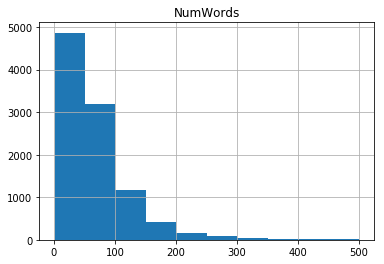

In [5]:
df.select('NumWords').toPandas().hist(range=[1, 500])

You can see that there are reviews with just one word and that there are reviews with a very high number of words but that for the most part most reviews are in the range of 50 words

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ae44150>]],
      dtype=object)

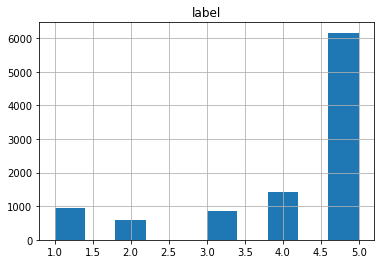

In [6]:
df.select('label').toPandas().hist(range=[1, 5])

You can see that we have a very unbalanced dataset, most of the reviews are 5, we will have to down sample that later on

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11b222310>]],
      dtype=object)

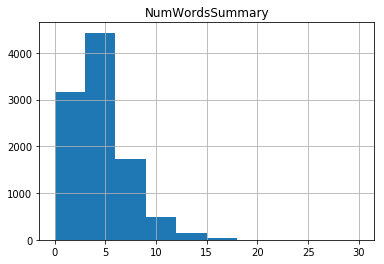

In [7]:
df.select('NumWordsSummary').toPandas().hist()

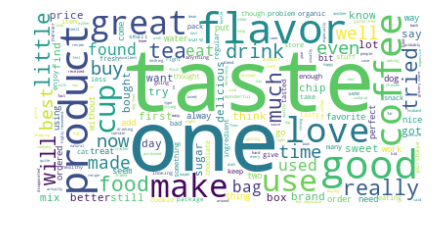

In [8]:
text = [x[0] for x in df.select('Text').collect()]
stopwords = set(STOPWORDS)
stopwords.update(['amazon', 'br'])
wordcloud = WordCloud(stopwords=stopwords, background_color='white').generate(' '.join(text))
plt.figure(figsize=[7,7])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Since this is a food review dataset it stands to reason that most of the words are food related

## Cleaning the Data

### Downsampling

In [9]:
# temp = df.filter(col('label') == 5)
# df = df.filter(col('label') != 5)
# temp = temp.sample(hyperparameters['downsample_ratio'])
# df = df.union(temp)

### Filtering Outliers

In [10]:
# df = df.filter(col('NumWords') > hyperparameters['min_words'])
# df = df.filter(col('NumWords') <= hyperparameters['max_words'])

## After Cleanup

In [11]:
min_words = df.select(min('NumWords')).collect()[0][0]
print 'min review length (in words)', min_words
max_words = df.select(max('NumWords')).collect()[0][0]
print 'max review length (in words)', max_words
print 'average review length (in words)', df.select(mean('NumWords')).collect()[0][0]

min review length (in words) 1
max review length (in words) 1255
average review length (in words) 69.4180524945


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11aea6490>]],
      dtype=object)

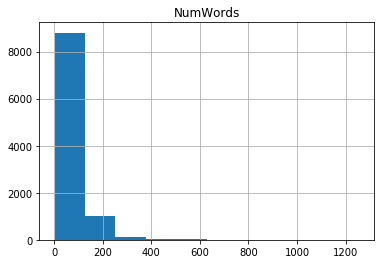

In [12]:
df.select('NumWords').toPandas().hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11afdee10>]],
      dtype=object)

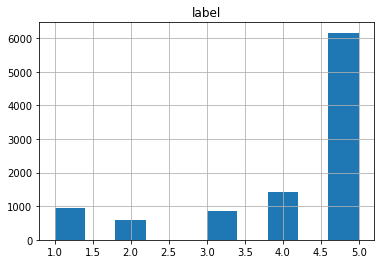

In [13]:
df.select('label').toPandas().hist(range=[1, 5])

## Feature Engineering

In [14]:
df = df.withColumn('NumWordsNormalized', (col('NumWords') - min_words) / (max_words - min_words))
df = df.withColumn('ExclamationPoints', size(split(col('Text'), r'!')) - 1)

## Clustering

In [15]:
# dataset = df.select('NumWords', 'Score')
# data = [(Vectors.dense([x[0], x[1]]),) for x in dataset.collect()]
# dataset = spark.createDataFrame(data, ['features'])
# kmeans = KMeans().setK(5).setSeed(1)
# model = kmeans.fit(dataset)
# predictions = model.transform(dataset)
# evaluator = ClusteringEvaluator()
# silhouette = evaluator.evaluate(predictions)
# print 'Silhouette with squared euclidean distance = ' + str(silhouette)
# centers = model.clusterCenters()
# print 'Cluster Centers: '
# for center in centers:
#     print(center)

In [16]:
# %matplotlib inline

# import matplotlib.pyplot as plt

# # plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

# centers = model.clusterCenters()
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

## Classification

In [17]:
(trainingData, testData) = df.randomSplit([0.7, 0.3], seed=42)

def evaluate(predictions, prediction_column):
    predictionAndLabels = sc.parallelize([(float(x[0]), float(x[1])) 
                                      for x in predictions.select(prediction_column, 'label').collect()])
    metrics = MulticlassMetrics(predictionAndLabels)
    print 'Summary Stats'
    print 'Accuracy = %s' % metrics.accuracy
    print 'Precision = %s' % metrics.precision()
    print 'Recall = %s' % metrics.recall()
    print 'F1 Score = %s' % metrics.fMeasure()
    for label in [float(x) for x in range(1, 6)]:
        print 'Class %s precision = %s' % (label, metrics.precision(label))
        print 'Class %s recall = %s' % (label, metrics.recall(label))
        print 'Class %s F1 Measure = %s' % (label, metrics.fMeasure(label, beta=1.0))
    print 'Weighted recall = %s' % metrics.weightedRecall
    print 'Weighted precision = %s' % metrics.weightedPrecision
    print 'Weighted F(1) Score = %s' % metrics.weightedFMeasure()
    print 'Weighted F(0.5) Score = %s' % metrics.weightedFMeasure(beta=0.5)
    print 'Weighted false positive rate = %s' % metrics.weightedFalsePositiveRate

### NaiveBayes

In [18]:
predictions = NaiveBayes(smoothing=hyperparameters['nb_smoothing'], 
                         modelType='multinomial').fit(trainingData).transform(testData)
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',
                                              metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print 'Test Error = %g ' % (1.0 - accuracy)
evaluate(predictions, 'prediction')

Test Error = 0.893775 
Summary Stats
Accuracy = 0.106224627876
Precision = 0.106224627876
Recall = 0.106224627876
F1 Score = 0.106224627876
Class 1.0 precision = 0.153284671533
Class 1.0 recall = 0.0729166666667
Class 1.0 F1 Measure = 0.0988235294118
Class 2.0 precision = 0.102362204724
Class 2.0 recall = 0.139784946237
Class 2.0 F1 Measure = 0.118181818182
Class 3.0 precision = 0.115879828326
Class 3.0 recall = 0.213438735178
Class 3.0 F1 Measure = 0.150208623088
Class 4.0 precision = 0.116712328767
Class 4.0 recall = 0.514492753623
Class 4.0 F1 Measure = 0.190263510496
Class 5.0 precision = 0.0
Class 5.0 recall = 0.0
Class 5.0 F1 Measure = 0.0
Weighted recall = 0.106224627876
Weighted precision = 0.0476393288756
Weighted F(1) Score = 0.0565679531931
Weighted F(0.5) Score = 0.0492940452472
Weighted false positive rate = 0.111275875595


### Logistic Regression

In [19]:
predictions = LogisticRegression(maxIter=hyperparameters['lr_iterations'], 
                                 regParam=hyperparameters['lr_regparam'], 
                                 elasticNetParam=hyperparameters['lr_elastic']).fit(
    trainingData).transform(testData)
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction',
                                              metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print 'Test Error = %g ' % (1.0 - accuracy)
evaluate(predictions, 'prediction')

Test Error = 0.386333 
Summary Stats
Accuracy = 0.613667117727
Precision = 0.613667117727
Recall = 0.613667117727
F1 Score = 0.613667117727
Class 1.0 precision = 0.0
Class 1.0 recall = 0.0
Class 1.0 F1 Measure = 0.0
Class 2.0 precision = 0.0
Class 2.0 recall = 0.0
Class 2.0 F1 Measure = 0.0
Class 3.0 precision = 0.0
Class 3.0 recall = 0.0
Class 3.0 F1 Measure = 0.0
Class 4.0 precision = 0.0
Class 4.0 recall = 0.0
Class 4.0 F1 Measure = 0.0
Class 5.0 precision = 0.613667117727
Class 5.0 recall = 1.0
Class 5.0 F1 Measure = 0.760587002096
Weighted recall = 0.613667117727
Weighted precision = 0.376587331379
Weighted F(1) Score = 0.466747233357
Weighted F(0.5) Score = 0.408121480993
Weighted false positive rate = 0.613667117727


### Random Forest

In [20]:
labelIndexer = StringIndexer(inputCol='label', outputCol='indexedLabel').fit(df)
featureIndexer = VectorIndexer(inputCol='features', outputCol='indexedFeatures', 
                               maxCategories=hyperparameters['rf_max_categories']).fit(df)
rf = RandomForestClassifier(labelCol='indexedLabel', featuresCol='indexedFeatures', 
                            numTrees=hyperparameters['rf_num_trees'])
labelConverter = IndexToString(inputCol='prediction', outputCol='predictedLabel',
                               labels=labelIndexer.labels)
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])
model = pipeline.fit(trainingData)
predictions = model.transform(testData)
evaluator = MulticlassClassificationEvaluator(labelCol='indexedLabel', 
                                              predictionCol='prediction', metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print 'Test Error = %g ' % (1.0 - accuracy)
evaluate(predictions, 'predictedLabel')

Test Error = 0.386333 
Summary Stats
Accuracy = 0.613667117727
Precision = 0.613667117727
Recall = 0.613667117727
F1 Score = 0.613667117727
Class 1.0 precision = 0.0
Class 1.0 recall = 0.0
Class 1.0 F1 Measure = 0.0
Class 2.0 precision = 0.0
Class 2.0 recall = 0.0
Class 2.0 F1 Measure = 0.0
Class 3.0 precision = 0.0
Class 3.0 recall = 0.0
Class 3.0 F1 Measure = 0.0
Class 4.0 precision = 0.0
Class 4.0 recall = 0.0
Class 4.0 F1 Measure = 0.0
Class 5.0 precision = 0.613667117727
Class 5.0 recall = 1.0
Class 5.0 F1 Measure = 0.760587002096
Weighted recall = 0.613667117727
Weighted precision = 0.376587331379
Weighted F(1) Score = 0.466747233357
Weighted F(0.5) Score = 0.408121480993
Weighted false positive rate = 0.613667117727
